In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import pathlib
import numpy as np
import pandas as pd

seed_ = 42

dim = 16
directory = pathlib.Path("../events/MG3")

n_3b = 250000
n_all4b = 250000

# shortcut: load short and shuffled version data

df_3b = pd.read_hdf(directory / "dataframes" / f"threeTag_picoAOD_{n_3b}.h5")
df_bg4b = pd.read_hdf(directory / "dataframes" / f"fourTag_10x_picoAOD_{n_all4b}.h5")
df_hh4b = pd.read_hdf(directory / "dataframes" / f"HH4b_picoAOD_{n_all4b}.h5")

df_3b["signal"] = False
df_bg4b["signal"] = False
df_hh4b["signal"] = True

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_hh4b))

3b-jet events:  250000
4b-jet events:  250000
HH4b-jet events:  30856


In [3]:
features = ["sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
            "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
            "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",
            "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m"]

In [4]:
signal_ratio = 0.05
    
import pytorch_lightning as pl
from torch.utils.data import TensorDataset

pl.seed_everything(seed_)
np.random.seed(seed_)

test_ratio = 0.5

n_3b_train = int(n_3b * (1 - test_ratio))
n_all4b_train = int(n_all4b * (1 - test_ratio))
n_bg4b_train = n_all4b_train - int(n_all4b_train * signal_ratio)
n_hh4b_train = int(n_all4b_train * signal_ratio)


df_3b_train = df_3b.iloc[:n_3b_train]
df_bg4b_train = df_bg4b.iloc[:n_bg4b_train]
df_hh4b_train = df_hh4b.iloc[:n_hh4b_train]
# reweight to match signal_ratio
df_hh4b_train.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_train["weight"]) / np.sum(df_hh4b_train["weight"])) * df_hh4b_train["weight"]
df_train = pd.concat([df_3b_train, df_bg4b_train, df_hh4b_train])
# shuffle the data
df_train = df_train.sample(frac=1, random_state=seed_).reset_index(drop=True)

n_3b_test = n_3b - n_3b_train
n_all4b_test = n_all4b - n_all4b_train
n_bg4b_test = n_all4b_test - int(n_all4b_test * signal_ratio)
n_hh4b_test = int(n_all4b_test * signal_ratio)

df_3b_test = df_3b.iloc[n_3b_train:n_3b_train+n_3b_test]
df_bg4b_test = df_bg4b.iloc[n_bg4b_train:n_bg4b_train+n_bg4b_test]
df_hh4b_test = df_hh4b.iloc[n_hh4b_train:n_hh4b_train+n_hh4b_test]
df_hh4b_test.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_test["weight"]) / np.sum(df_hh4b_test["weight"])) * df_hh4b_test["weight"]
df_test = pd.concat([df_3b_test, df_bg4b_test, df_hh4b_test])
df_test = df_test.sample(frac=1, random_state=seed_).reset_index(drop=True)

# reduce number of 4b samples to 1/8
print("4b ratio: ", df_train.loc[df_train["fourTag"], "weight"].sum() / df_train["weight"].sum())
print("Signal ratio: ", df_train.loc[df_train["signal"], "weight"].sum() / df_train.loc[df_train["fourTag"], "weight"].sum())

from split_samples import split_samples

(X_train, y_train, w_train, is_signal_train), (X_val, y_val, w_val, is_signal_val) = split_samples(
    df_train[features].values, df_train["fourTag"].values, df_train["weight"].values, df_train["signal"].values,
    at=2/3, div=1024)

X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.long)
w_val_torch = torch.tensor(w_val, dtype=torch.float32)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                torch.tensor(y_train, dtype=torch.long),
                                torch.tensor(w_train, dtype=torch.float32))
val_dataset = TensorDataset(X_val_torch, y_val_torch, w_val_torch)

###########################################################################################
###########################################################################################

from fvt_classifier import FvTClassifier

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 50
run_name = "_".join(["fvt_picoAOD", 
                    f"signal_ratio={signal_ratio}", 
                    f"dijet={dim_dijet_features}", 
                    f"quadjet={dim_quadjet_features}", 
                    f"n_3b={n_3b}",
                    f"n_all4b={n_all4b}",
                    f"epochs={max_epochs}",
                    f"seed={seed_}",
                    ])
lr = 1e-3

Seed set to 42


4b ratio:  0.4770373
Signal ratio:  0.050000004


# Test dataset (Not validation dataset)

In [5]:
print("Test Data")
from fvt_representations import get_fvt_reprs
from torch.utils.data import DataLoader

(X_test, y_test, w_test, is_signal_test), _ = split_samples(
    df_test[features].values, df_test["fourTag"].values, df_test["weight"].values, df_test["signal"].values,
    at=1)

X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)
w_test_torch = torch.tensor(w_test, dtype=torch.float32)

svb_test_dataset = TensorDataset(X_test_torch, y_test_torch, w_test_torch)

fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
fvt_model.eval()
test_loader = DataLoader(svb_test_dataset, batch_size=1024, shuffle=False)
device = torch.device("cuda:0")
fvt_model = fvt_model.to(device)

q_repr_test, view_scores_test = get_fvt_reprs(X_test_torch, fvt_model, device)
labels_4b_test = y_test
probs_4b_test = fvt_model.predict(X_test_torch)[:, 1].cpu().detach().numpy()

is_3b_test = labels_4b_test == 0
is_4b_test = labels_4b_test == 1
is_bg4b_test = (labels_4b_test == 1) & (is_signal_test == 0)
is_hh4b_test = (labels_4b_test == 1) & (is_signal_test == 1)

Test Data


**Test Data**


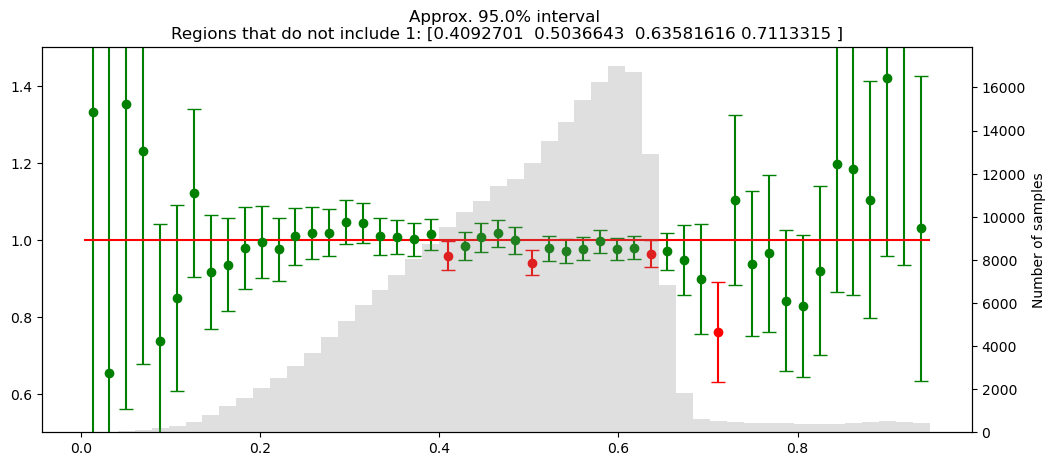

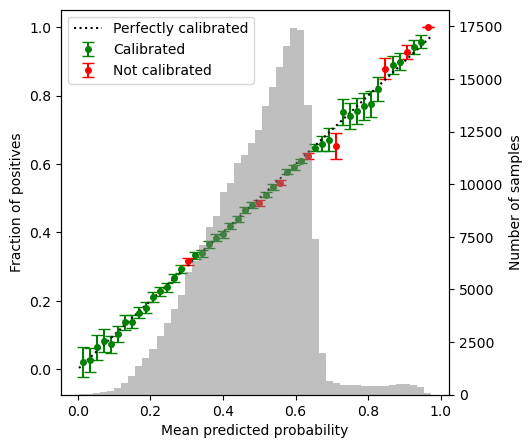

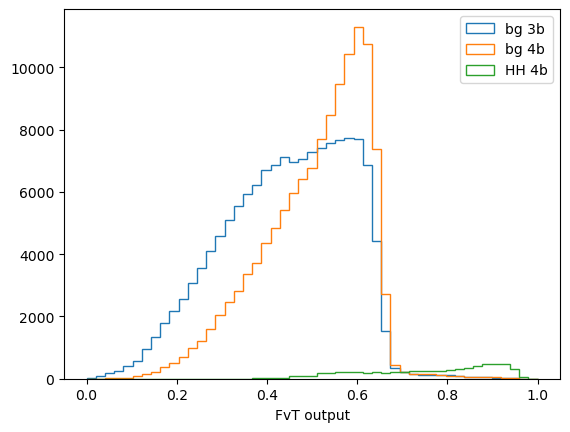

In [6]:
from matplotlib import pyplot as plt
from plots import plot_prob_weighted_histogram1d, calibration_plot

print("**Test Data**")


plot_prob_weighted_histogram1d(probs_4b_test, probs_4b_test, labels_4b_test,
                               n_bins=50, 
                               sample_weights=w_test,
                               ylim=(0.5, 1.5))
calibration_plot(probs_4b_test, labels_4b_test,
                 bins=50,
                 sample_weights=w_test)

fig, ax = plt.subplots()
bins_range = np.linspace(0, 1, 50)
ax.hist(probs_4b_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
ax.hist(probs_4b_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
ax.hist(probs_4b_test[is_hh4b_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_hh4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Thresholded samples
3b:  3498
bg4b:  5510
hh4b:  992


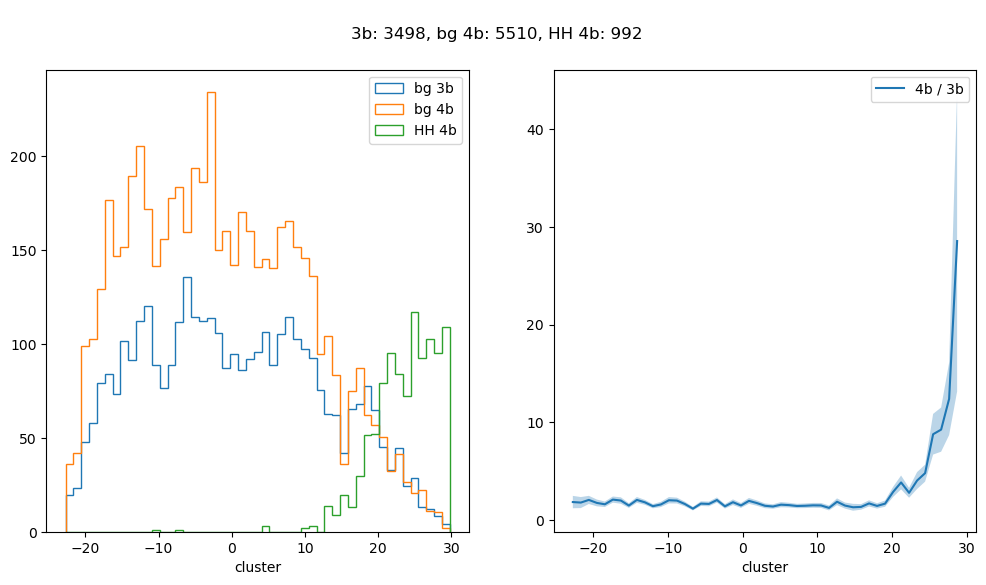

Failed samples
3b:  106826
bg4b:  90145
hh4b:  1249


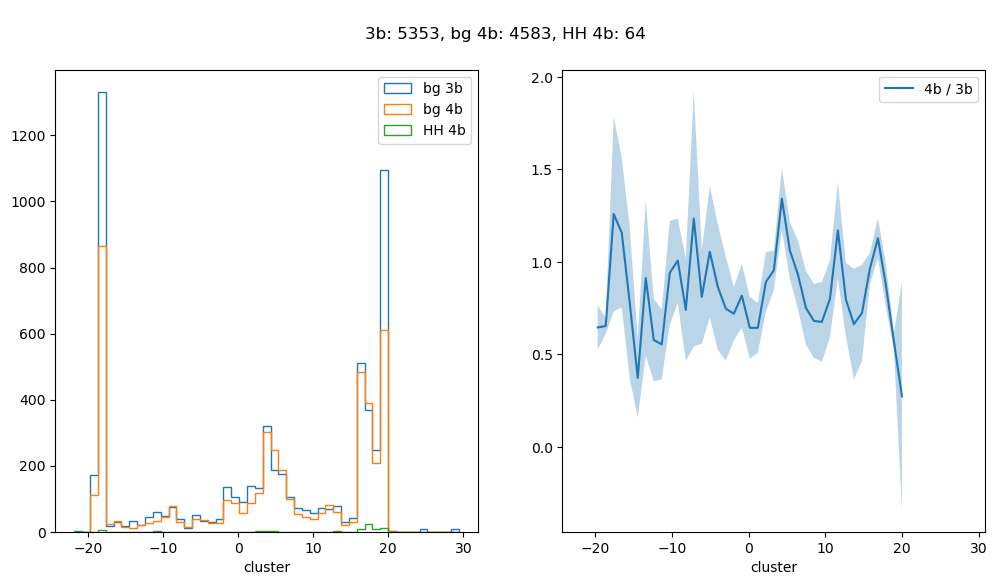

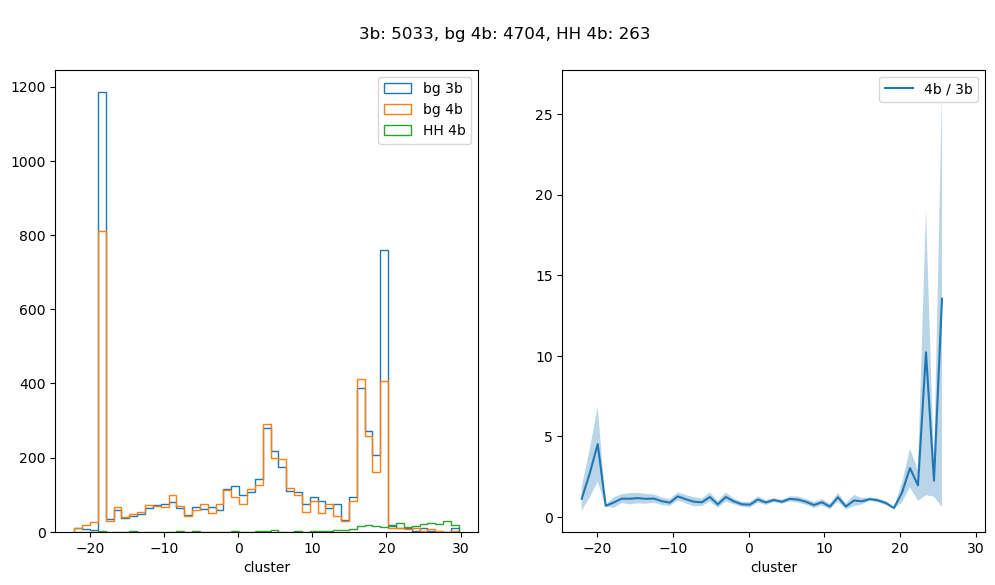

In [7]:
import umap
from sklearn.manifold import TSNE
from plots import plot_cluster

n_components = 1
umap_reducer = umap.UMAP(n_components=n_components)
tsne_reducer = TSNE(n_components=n_components, random_state=seed_)

reducer = umap_reducer

# TSNE seems not to work well
# tsne_reducer.transform is not implemented
# reducer = tsne_reducer

# random sample of 10000 points

probs_4b_threshold = 0.6
probs_4b_exceeded = probs_4b_test > probs_4b_threshold

n_points = min(np.sum(probs_4b_exceeded), 10000)
np.random.seed(seed_)
cluster_samples = np.random.choice(np.where(probs_4b_exceeded)[0], n_points, replace=False)
# cluster_samples = np.random.choice(np.where(~probs_4b_exceeded)[0], n_points, replace=False)
# cluster_samples = np.random.choice(np.where(probs_4b_exceeded & (~is_signal_test))[0], n_points, replace=False)
q_repr_cluster = q_repr_test[cluster_samples]
is_3b_cluster = labels_4b_test[cluster_samples] == 0
is_bg4b_cluster = (labels_4b_test[cluster_samples] == 1) & (is_signal_test[cluster_samples] == 0)
is_hh4b_cluster = is_signal_test[cluster_samples] == 1
weights_cluster = w_test[cluster_samples]
view_scores_cluster = view_scores_test[cluster_samples]

# print number of points in each class
print("Thresholded samples")
print("3b: ", np.sum(is_3b_cluster))
print("bg4b: ", np.sum(is_bg4b_cluster))
print("hh4b: ", np.sum(is_hh4b_cluster))

# cluster_repr_test = umap_reducer.fit_transform(q_repr_cluster.reshape(-1, 3*dim_quadjet_features))

# plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)

att_q_repr_cluster = (q_repr_cluster @ view_scores_cluster[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_test = reducer.fit_transform(att_q_repr_cluster)

plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)


# failed samples
print("Failed samples")
print("3b: ", np.sum(is_3b_test & ~probs_4b_exceeded))
print("bg4b: ", np.sum(is_bg4b_test & ~probs_4b_exceeded))
print("hh4b: ", np.sum(is_hh4b_test & ~probs_4b_exceeded))

thrs_fail_samples = np.random.choice(np.where(probs_4b_test < probs_4b_threshold)[0], min(n_points, np.sum(probs_4b_test < probs_4b_threshold)), replace=False)
q_repr_fail = q_repr_test[thrs_fail_samples]
is_3b_fail = labels_4b_test[thrs_fail_samples] == 0
is_bg4b_fail = (labels_4b_test[thrs_fail_samples] == 1) & (is_signal_test[thrs_fail_samples] == 0)
is_hh4b_fail = is_signal_test[thrs_fail_samples] == 1
weights_fail = w_test[thrs_fail_samples]
view_scores_fail = view_scores_test[thrs_fail_samples]

att_q_repr_fail = (q_repr_fail @ view_scores_fail[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_fail = reducer.transform(att_q_repr_fail)

plot_cluster(cluster_repr_fail, is_3b_fail, is_bg4b_fail, is_hh4b_fail, weights_fail, n_components=n_components)


# all samples
np.random.seed(seed_)
cluster_samples = np.random.choice(np.arange(len(probs_4b_test)), 10000, replace=False)
q_repr_cluster = q_repr_test[cluster_samples]
is_3b_cluster = labels_4b_test[cluster_samples] == 0
is_bg4b_cluster = (labels_4b_test[cluster_samples] == 1) & (is_signal_test[cluster_samples] == 0)
is_hh4b_cluster = is_signal_test[cluster_samples] == 1
weights_cluster = w_test[cluster_samples]
view_scores_cluster = view_scores_test[cluster_samples]

att_q_repr_cluster = (q_repr_cluster @ view_scores_cluster[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_test = reducer.transform(att_q_repr_cluster)

plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)

att_q_repr_test = (q_repr_test @ view_scores_test[:, :, None]).reshape(-1, dim_quadjet_features)
umap_embed_test = reducer.transform(att_q_repr_test)

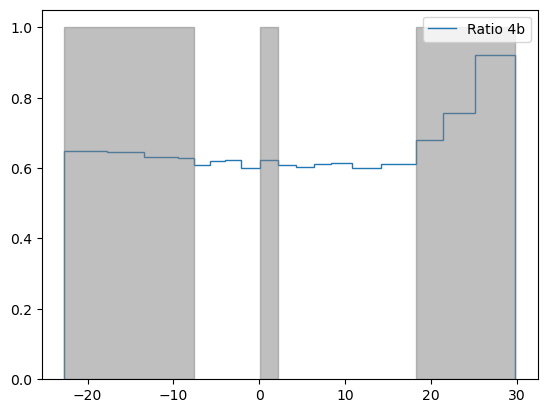

In [9]:
n_bins = 20
umap_embed_exceeded = umap_embed_test[probs_4b_exceeded]
is_3b_exceeded = labels_4b_test[probs_4b_exceeded] == 0
is_4b_exceeded = labels_4b_test[probs_4b_exceeded] == 1
is_bg4b_exceeded = (labels_4b_test[probs_4b_exceeded] == 1) & (is_signal_test[probs_4b_exceeded] == 0)
is_hh4b_exceeded = (labels_4b_test[probs_4b_exceeded] == 1) & (is_signal_test[probs_4b_exceeded] == 1)
w_exceeded = w_test[probs_4b_exceeded]

percentiles = np.percentile(umap_embed_exceeded[:, 0], np.linspace(0, 100, n_bins + 1))

hist_3b, _ = np.histogram(umap_embed_exceeded[is_3b_exceeded, 0], bins=percentiles, weights=w_exceeded[is_3b_exceeded])
hist_bg4b, _ = np.histogram(umap_embed_exceeded[is_bg4b_exceeded, 0], bins=percentiles, weights=w_exceeded[is_bg4b_exceeded])
hist_hh4b, _ = np.histogram(umap_embed_exceeded[is_hh4b_exceeded, 0], bins=percentiles, weights=w_exceeded[is_hh4b_exceeded])

ratio_4b = (hist_bg4b + hist_hh4b) / (hist_3b + hist_bg4b + hist_hh4b)

fig, ax = plt.subplots()
ax.stairs(ratio_4b, percentiles, fill=False, label="Ratio 4b")
ax.legend()

signal_region_ratio = 0.5
n_top = int(n_bins * signal_region_ratio)
top_bins = np.argsort(ratio_4b)[-n_top:]

# merge top_bins
top_bins = np.sort(top_bins)
top_bin_edges = [(percentiles[i], percentiles[i+1]) for i in top_bins]
for i, (low, high) in enumerate(top_bin_edges):
    if i == 0:
        merged_bin_edges = [(low, high)]
    else:
        prev_low, prev_high = merged_bin_edges[-1]
        if low <= prev_high:
            merged_bin_edges[-1] = (prev_low, high)
        else:
            merged_bin_edges.append((low, high))


for low, high in merged_bin_edges:
    rect = plt.Rectangle((low, 0), high - low, 1, color="gray", alpha=0.5)
    ax.add_patch(rect)

plt.show()
plt.close()

is_in_sr = np.any([((umap_embed_test[:, 0] >= low) & (umap_embed_test[:, 0] < high)) 
                    for low, high in merged_bin_edges], axis=0) & probs_4b_exceeded

is_in_sb = probs_4b_exceeded & ~is_in_sr

In [10]:
discard_failed = True

sb_run_name = "_".join(
    [
        run_name,
        "sb",
        f"signal_region_ratio={signal_region_ratio}",
        f"probs_4b_threshold={probs_4b_threshold}",
        "pick_high_ratio_4b_exceeded",
    ]
    + (["discard_failed"]
    if discard_failed
    else [])
)

train_sb = False

X_sb = X_test[is_in_sb]
y_sb = y_test[is_in_sb]
w_sb = w_test[is_in_sb]

(X_sb_train, y_sb_train, w_sb_train), (X_sb_val, y_sb_val, w_sb_val) = split_samples(X_sb, y_sb, w_sb, at=2/3, div=1024)

sb_train_dataset = TensorDataset(torch.tensor(X_sb_train, dtype=torch.float32),
                                torch.tensor(y_sb_train, dtype=torch.long),
                                torch.tensor(w_sb_train, dtype=torch.float32))

X_sb_val_torch = torch.tensor(X_sb_val, dtype=torch.float32)
y_sb_val_torch = torch.tensor(y_sb_val, dtype=torch.long)
w_sb_val_torch = torch.tensor(w_sb_val, dtype=torch.float32)

sb_val_dataset = TensorDataset(X_sb_val_torch, y_sb_val_torch, w_sb_val_torch)

# Train SB FvT 

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 20
lr = 1e-3

if train_sb:
    pl.seed_everything(42)

    sb_model = FvTClassifier(num_classes, 
                        dim_input_jet_features, 
                        dim_dijet_features, 
                        dim_quadjet_features, 
                        run_name=sb_run_name,
                        device=torch.device("cuda:0"),
                        lr=lr)

    sb_model.fit(sb_train_dataset, sb_val_dataset, batch_size=1024, max_epochs=max_epochs)

/home/soheuny/HH4bsim/playground/plots.py:44: RuntimeWarning: divide by zero encountered in divide
  ratio_mean = hist_4b / w_hist_3b
/home/soheuny/HH4bsim/playground/plots.py:44: RuntimeWarning: invalid value encountered in divide
  ratio_mean = hist_4b / w_hist_3b
/home/soheuny/HH4bsim/playground/plots.py:46: RuntimeWarning: divide by zero encountered in divide
  hist_4b * (1 / w_hist_3b) ** 2 + w_sq_hist_3b * (hist_4b / w_hist_3b**2) ** 2
/home/soheuny/HH4bsim/playground/plots.py:46: RuntimeWarning: invalid value encountered in multiply
  hist_4b * (1 / w_hist_3b) ** 2 + w_sq_hist_3b * (hist_4b / w_hist_3b**2) ** 2
/home/soheuny/HH4bsim/playground/plots.py:46: RuntimeWarning: invalid value encountered in divide
  hist_4b * (1 / w_hist_3b) ** 2 + w_sq_hist_3b * (hist_4b / w_hist_3b**2) ** 2


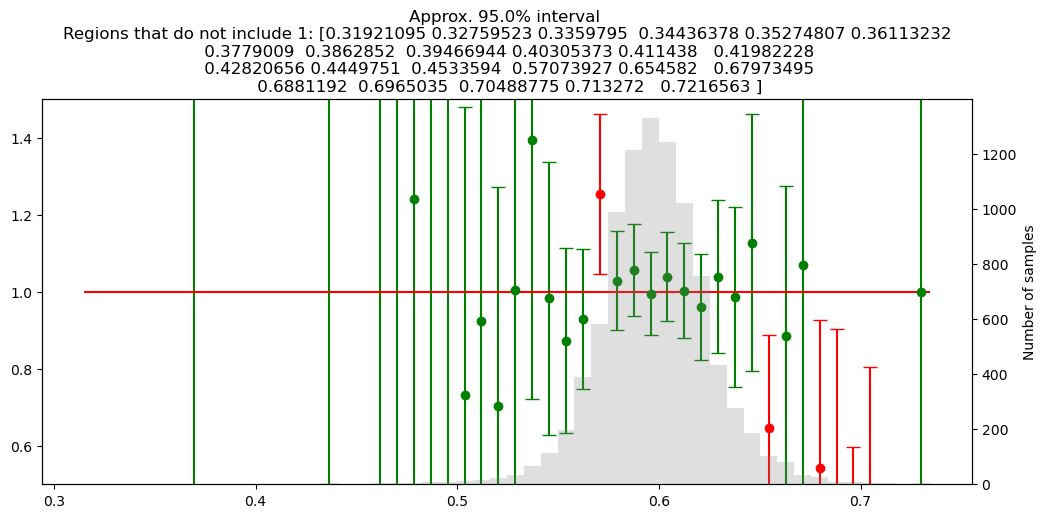

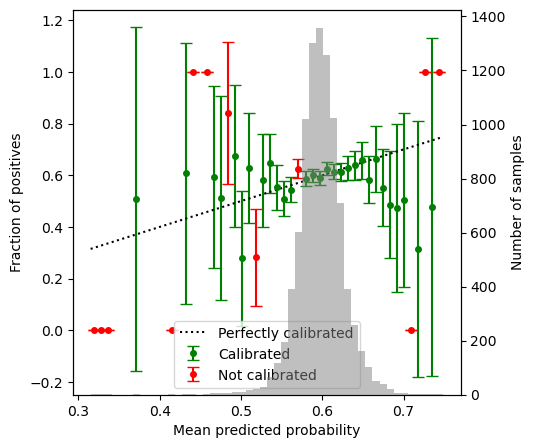

In [11]:
from plots import plot_prob_weighted_histogram1d, calibration_plot

sb_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{sb_run_name}_best.ckpt")
sb_model.eval()
q_repr_sb_val = get_fvt_reprs(X_sb_val_torch, sb_model)[0]
q_repr_sb_val = np.concatenate(q_repr_sb_val, axis=0)
labels_4b_sb_val = y_sb_val
probs_4b_sb_val = sb_model.predict(X_sb_val_torch)[:, 1].cpu().numpy()
weights_sb_val = w_sb_val


plot_prob_weighted_histogram1d(probs_4b_sb_val, 
                               probs_4b_sb_val, 
                               labels_4b_sb_val,
                               n_bins=50, 
                               sample_weights=weights_sb_val,
                               ylim=(0.5, 1.5))
calibration_plot(probs_4b_sb_val, labels_4b_sb_val,
                 bins=50,
                 sample_weights=weights_sb_val)

Sideband
3b:  10532.717
bg4b:  15895.319
hh4b:  554.2884


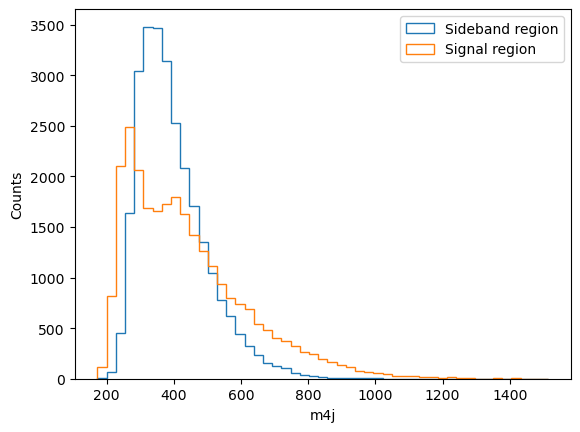

Signal Region
3b:  8449.127
bg4b:  13539.3125
hh4b:  4721.6235

Signal in Signal Region
hh4b:  0.72417754

samples in SR / (SR + SB)
0.49746457


In [12]:
is_3b_sb = is_3b_test[is_in_sb]
is_4b_sb = is_4b_test[is_in_sb]
is_bg4b_sb = is_bg4b_test[is_in_sb]
is_hh4b_sb = is_hh4b_test[is_in_sb]


print("Sideband")
print("3b: ", np.sum(w_sb[is_3b_sb]))
print("bg4b: ", np.sum(w_sb[is_bg4b_sb]))
print("hh4b: ", np.sum(w_sb[is_hh4b_sb]))

X_sr = X_test[is_in_sr]
is_3b_sr = is_3b_test[is_in_sr]
is_4b_sr = is_4b_test[is_in_sr]
is_bg4b_sr = is_bg4b_test[is_in_sr]
is_hh4b_sr = is_hh4b_test[is_in_sr]
w_sr = w_test[is_in_sr]


# calculate m4j

from matplotlib import pyplot as plt
from ancillary_features import get_m4j

m4j_sb = get_m4j(torch.tensor(X_sb, dtype=torch.float32))
m4j_sr = get_m4j(torch.tensor(X_sr, dtype=torch.float32))

# plot histograms of m4j
bins_range = np.linspace(min(np.min(m4j_sb), np.min(m4j_sr)), max(np.max(m4j_sb), np.max(m4j_sr)), 50)

plt.hist(m4j_sb, bins=bins_range, weights=w_sb, histtype="step", label="Sideband region")
plt.hist(m4j_sr, bins=bins_range, weights=w_sr, histtype="step", label="Signal region")
plt.xlabel("m4j")
plt.ylabel("Counts")
plt.legend()
plt.show()
plt.close()


# print weights of 3b, bg4b, hh4b

print("Signal Region")
print("3b: ", np.sum(w_sr[is_3b_sr]))
print("bg4b: ", np.sum(w_sr[is_bg4b_sr]))
print("hh4b: ", np.sum(w_sr[is_hh4b_sr]))
print("")
print("Signal in Signal Region")
print("hh4b: ", np.sum(w_sr[is_hh4b_sr]) / np.sum(w_test[is_hh4b_test]))
print("")
print("samples in SR / (SR + SB)")
print(np.sum(w_sr) / (np.sum(w_sr) + np.sum(w_sb)))

X_sr_torch = torch.tensor(X_sr, dtype=torch.float32)
probs_4b_sb_sr = sb_model.predict(X_sr_torch)[:, 1].cpu().numpy()
probs_4b_fvt_sr = fvt_model.predict(X_sr_torch)[:, 1].cpu().numpy()

In [13]:
def plot_reweighting(hist_x_test, name, geom):

    hist_x_sr = hist_x_test[is_in_sr]
    hist_x_sb = hist_x_test[is_in_sb]

    # reweight 3b samples by probs_4b_sb_sr / (1 - probs_4b_sb_sr)

    total_3b_sb = np.sum(w_sb[is_3b_sb])
    total_4b_sb = np.sum(w_sb[is_4b_sb])

    total_3b_sr = np.sum(w_sr[is_3b_sr])
    total_4b_sr = np.sum(w_sr[is_4b_sr])

    total_3b_fvt = np.sum(w_test[is_3b_test])
    total_4b_fvt = np.sum(w_test[is_4b_test])

    sb_reweight_const = (total_4b_sr / total_3b_sr) / (total_4b_sb / total_3b_sb)
    fvt_reweight_const = (total_4b_sr / total_3b_sr) / (total_4b_fvt / total_3b_fvt)

    reweights_sb_sr = w_sr * np.where(
        is_3b_sr, sb_reweight_const * (probs_4b_sb_sr / (1 - probs_4b_sb_sr)), 1
    )
    reweights_fvt_sr = w_sr * np.where(
        is_3b_sr, fvt_reweight_const * (probs_4b_fvt_sr / (1 - probs_4b_fvt_sr)), 1
    )

    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
    # bins to be a geometric sequence

    if geom:
        bins_range = np.geomspace(hist_x_test.min(), hist_x_test.max(), 30)
    else:
        bins_range = np.linspace(hist_x_test.min(), hist_x_test.max(), 30)

    hist_3b, _ = np.histogram(
        hist_x_sr[is_3b_sr], bins=bins_range, weights=w_sr[is_3b_sr]
    )
    hist_rwsb3b, _ = np.histogram(
        hist_x_sr[is_3b_sr], bins=bins_range, weights=reweights_sb_sr[is_3b_sr]
    )
    hist_rwfvt3b, _ = np.histogram(
        hist_x_sr[is_3b_sr], bins=bins_range, weights=reweights_fvt_sr[is_3b_sr]
    )
    hist_bg4b, _ = np.histogram(
        hist_x_sr[is_bg4b_sr], bins=bins_range, weights=w_sr[is_bg4b_sr]
    )

    # normalize the histograms
    scale_3b = np.sum(hist_bg4b) / np.sum(hist_3b)
    scale_rwsb3b = np.sum(hist_bg4b) / np.sum(hist_rwsb3b)
    scale_rwfvt3b = np.sum(hist_bg4b) / np.sum(hist_rwfvt3b)

    err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
    err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
    err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b

    ax[0].stairs(hist_3b, bins_range, label="3b")
    ax[0].stairs(hist_rwsb3b, bins_range, label="SB reweighted 3b")
    ax[0].stairs(hist_rwfvt3b, bins_range, label="FvT reweighted 3b")
    ax[0].stairs(hist_bg4b, bins_range, label="bg4b")
    ax[0].set_xlabel(name)
    ax[0].set_ylabel("Counts")
    ax[0].legend()
    ax[0].set_title("Reweighted 3b vs bg4b")

    z = 1.96
    ax[1].errorbar(
        (bins_range[1:] + bins_range[:-1]) / 2,
        scale_3b * hist_3b / hist_bg4b,
        yerr=z * err_3b,
        fmt="o-",
        label="bg4b/3b",
        capsize=5,
        markersize=2,
    )
    ax[1].errorbar(
        (bins_range[1:] + bins_range[:-1]) / 2,
        scale_rwsb3b * hist_rwsb3b / hist_bg4b,
        yerr=z * err_rw3b,
        fmt="o-",
        label="bg4b/SB reweighted 3b",
        capsize=5,
        markersize=2,
    )
    ax[1].errorbar(
        (bins_range[1:] + bins_range[:-1]) / 2,
        scale_rwfvt3b * hist_rwfvt3b / hist_bg4b,
        yerr=z * err_rwfvt3b,
        fmt="o-",
        label="bg4b/FvT reweighted 3b",
        capsize=5,
        markersize=2,
    )
    ax[1].hlines(1, bins_range[0], bins_range[-1], color="black", linestyle="--")
    ax[1].set_ylim(0.5, 1.5)
    ax[1].set_xlabel(name)
    ax[1].set_ylabel("Ratio")
    ax[1].legend()
    ax[1].set_title("Reweighted 3b / bg4b")

    ax[2].hist(
        hist_x_sb,
        bins=bins_range,
        weights=w_sb,
        histtype="step",
        label="Sideband region",
    )
    ax[2].hist(
        hist_x_sr, bins=bins_range, weights=w_sr, histtype="step", label="Signal region"
    )
    ax[2].set_xlabel(name)
    ax[2].set_ylabel("Counts")
    ax[2].legend()
    ax[2].set_title("Signal region vs Sideband region")

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    if geom:
        bins_range = np.geomspace(hist_x_test.min(), hist_x_test.max(), 30)
    else:
        bins_range = np.linspace(hist_x_test.min(), hist_x_test.max(), 30)

    ax[0].hist(hist_x_test[is_3b_test], bins=bins_range, histtype="step", label="3b")
    ax[0].hist(
        hist_x_test[is_bg4b_test], bins=bins_range, histtype="step", label="bg4b"
    )
    ax[0].hist(
        hist_x_test[is_hh4b_test], bins=bins_range, histtype="step", label="hh4b"
    )
    ax[0].set_xlabel(name)
    ax[0].set_ylabel("Counts")
    ax[0].set_title("All samples")
    ax[0].legend()

    ax[1].hist(
        hist_x_test[is_3b_test & probs_4b_exceeded],
        bins=bins_range,
        histtype="step",
        label="3b",
    )
    ax[1].hist(
        hist_x_test[is_bg4b_test & probs_4b_exceeded],
        bins=bins_range,
        histtype="step",
        label="bg4b",
    )
    ax[1].hist(
        hist_x_test[is_hh4b_test & probs_4b_exceeded],
        bins=bins_range,
        histtype="step",
        label="hh4b",
    )
    ax[1].set_xlabel(name)
    ax[1].set_ylabel("Counts")
    ax[1].set_title(f"Prob4b > {probs_4b_threshold}")
    ax[1].legend()

    plt.show()
    plt.close()

/tmp/ipykernel_3424004/3690751894.py:53: RuntimeWarning: invalid value encountered in divide
  err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
/tmp/ipykernel_3424004/3690751894.py:54: RuntimeWarning: invalid value encountered in divide
  err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
/tmp/ipykernel_3424004/3690751894.py:55: RuntimeWarning: invalid value encountered in divide
  err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b
/tmp/ipykernel_3424004/3690751894.py:69: RuntimeWarning: invalid value encountered in divide
  scale_3b * hist_3b / hist_bg4b,
/tmp/ipykernel_3424004/3690751894.py:78: RuntimeWarning: invalid value encountered in divide
  scale_rwsb3b * hist_rwsb3b / hist_bg4b,
/tmp/ipykernel_3424004/3690751894.py:87: RuntimeWarning: invalid value encountered in divide
  scale_rwfvt3b * hist_rwfvt3b / hist_bg4b,


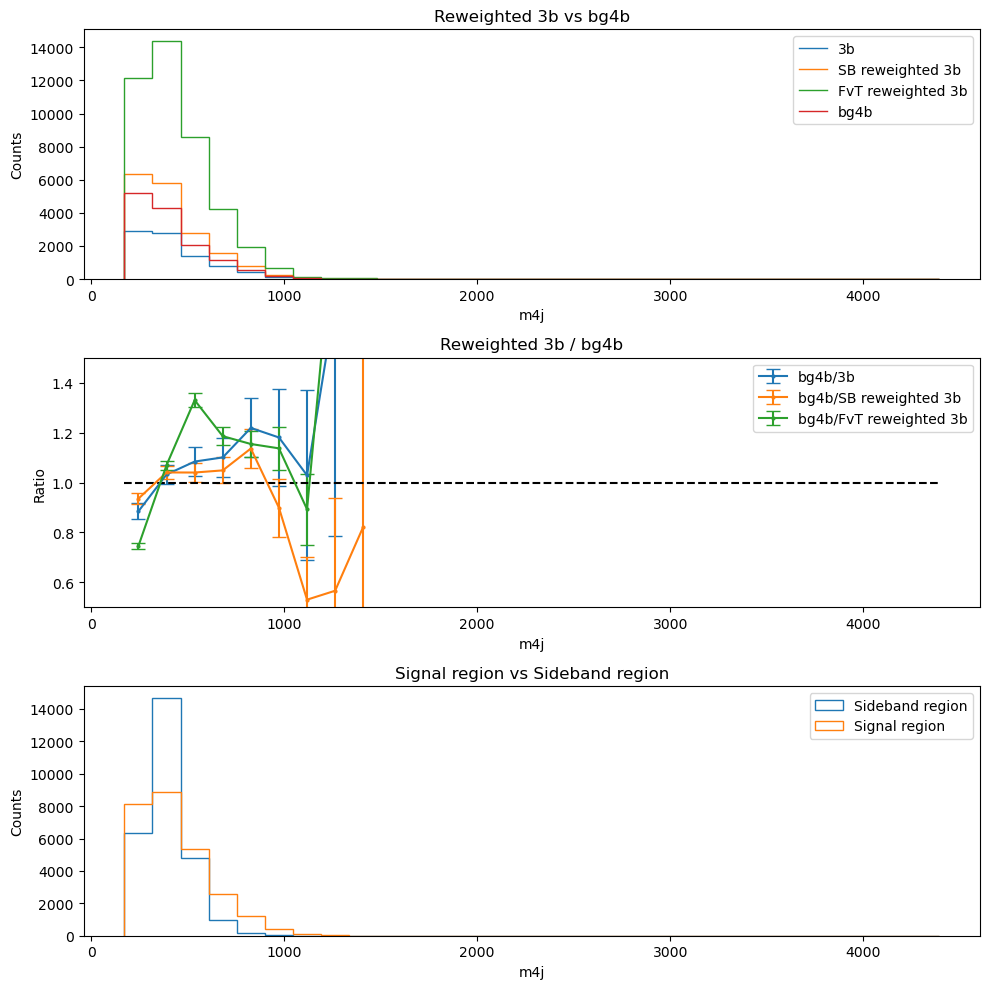

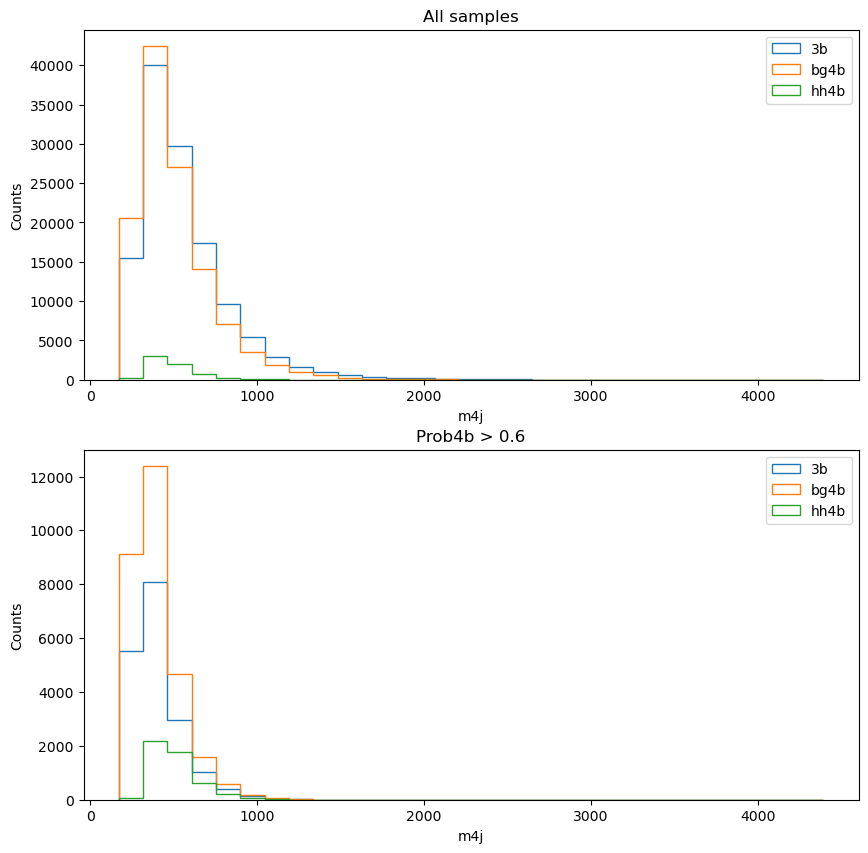

In [14]:
plot_reweighting(get_m4j(torch.tensor(X_test, dtype=torch.float32)), "m4j", geom=False)

/tmp/ipykernel_3424004/3690751894.py:53: RuntimeWarning: invalid value encountered in divide
  err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
/tmp/ipykernel_3424004/3690751894.py:54: RuntimeWarning: invalid value encountered in divide
  err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
/tmp/ipykernel_3424004/3690751894.py:55: RuntimeWarning: invalid value encountered in divide
  err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b
/tmp/ipykernel_3424004/3690751894.py:69: RuntimeWarning: invalid value encountered in divide
  scale_3b * hist_3b / hist_bg4b,
/tmp/ipykernel_3424004/3690751894.py:78: RuntimeWarning: invalid value encountered in divide
  scale_rwsb3b * hist_rwsb3b / hist_bg4b,
/tmp/ipykernel_3424004/3690751894.py:87: RuntimeWarning: invalid value encountered in divide
  scale_rwfvt3b * hist_rwfvt3b / hist_bg4b,


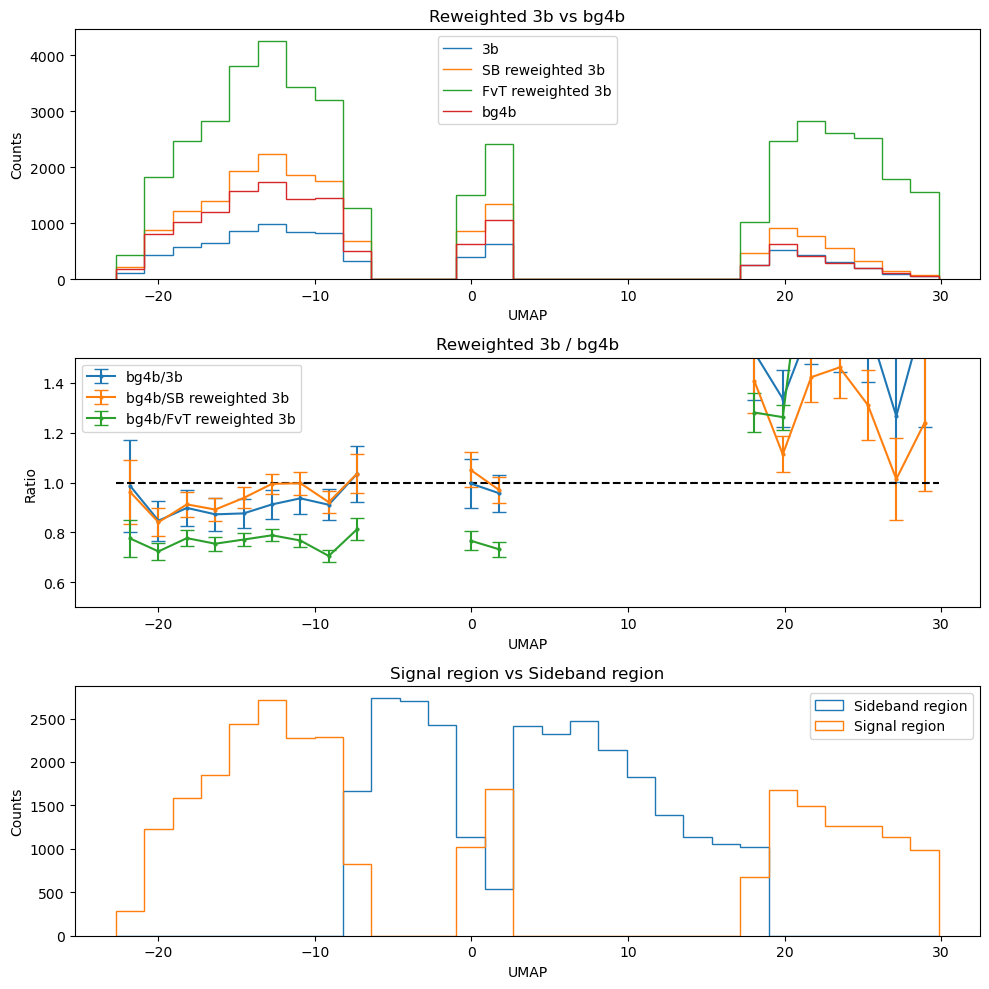

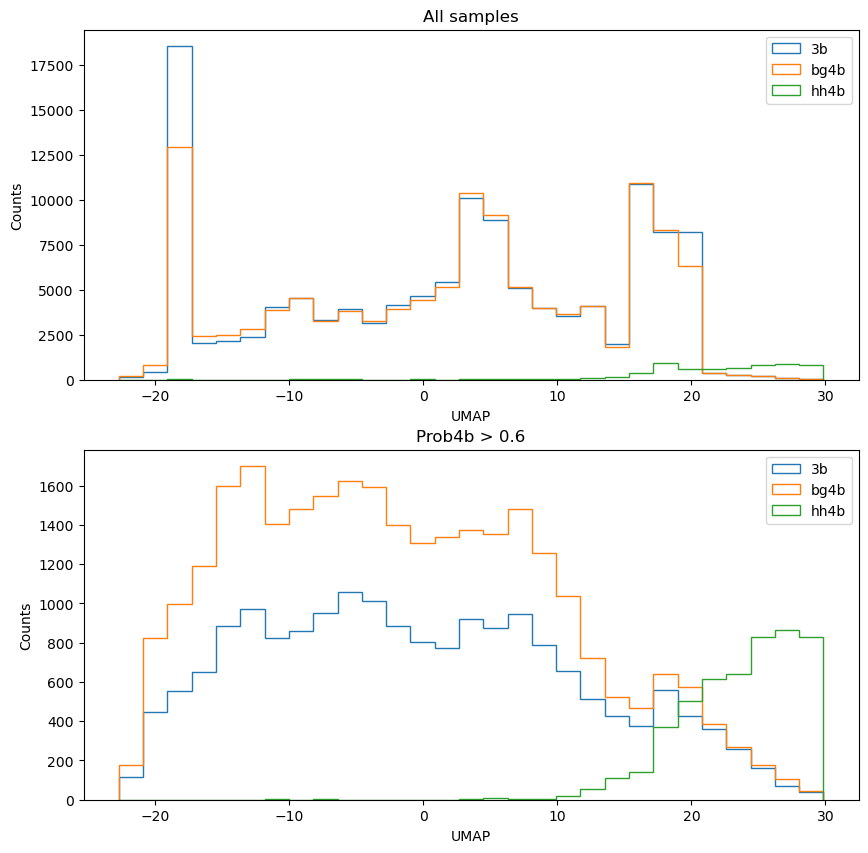

In [15]:
plot_reweighting(umap_embed_test[:, 0], "UMAP", geom=False)

/tmp/ipykernel_3424004/3690751894.py:53: RuntimeWarning: invalid value encountered in divide
  err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
/tmp/ipykernel_3424004/3690751894.py:54: RuntimeWarning: invalid value encountered in divide
  err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
/tmp/ipykernel_3424004/3690751894.py:55: RuntimeWarning: invalid value encountered in divide
  err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b
/tmp/ipykernel_3424004/3690751894.py:69: RuntimeWarning: invalid value encountered in divide
  scale_3b * hist_3b / hist_bg4b,
/tmp/ipykernel_3424004/3690751894.py:78: RuntimeWarning: invalid value encountered in divide
  scale_rwsb3b * hist_rwsb3b / hist_bg4b,
/tmp/ipykernel_3424004/3690751894.py:87: RuntimeWarning: invalid value encountered in divide
  scale_rwfvt3b * hist_rwfvt3b / hist_bg4b,


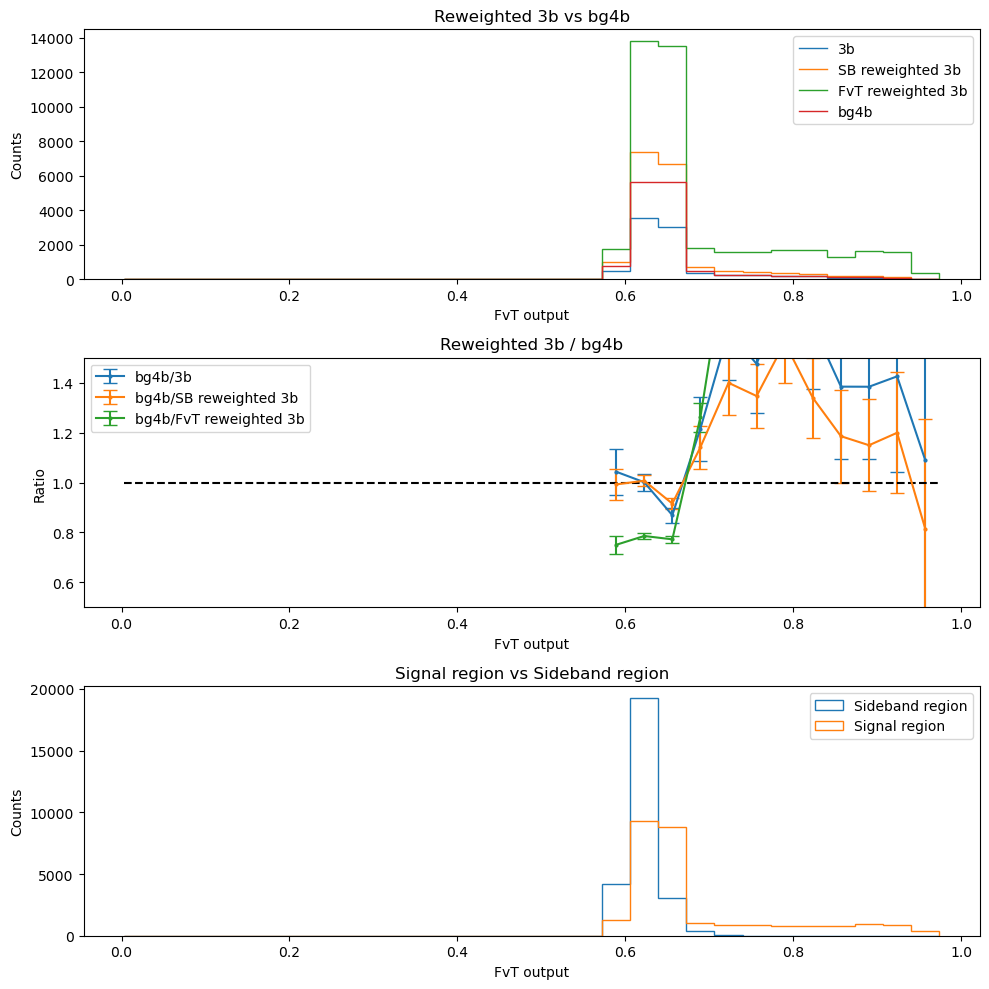

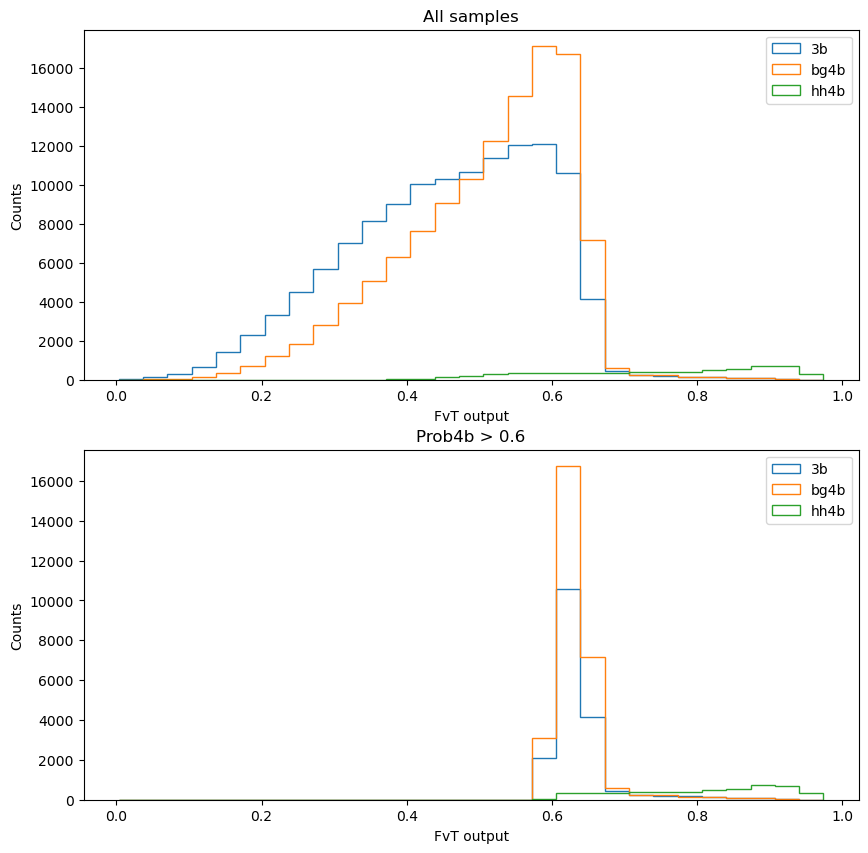

In [16]:
plot_reweighting(probs_4b_test, "FvT output", geom=False)

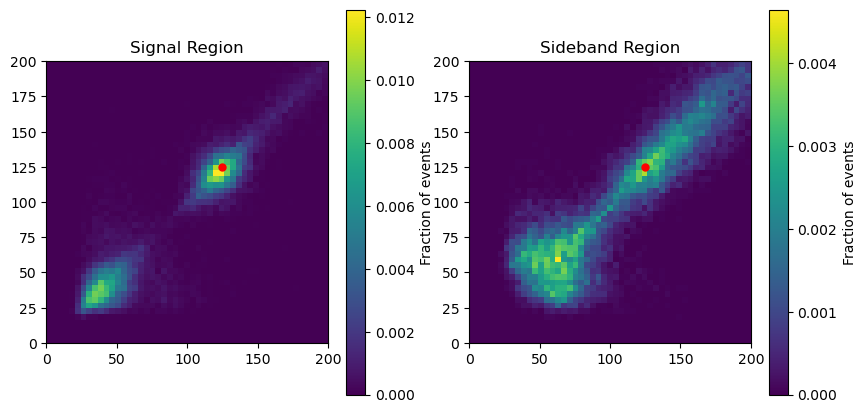

In [17]:
from ancillary_features import jets_to_dijets


jet0 = X_test_torch[:, [4*i for i in range(4)]]
jet1 = X_test_torch[:, [4*i + 1 for i in range(4)]]
jet2 = X_test_torch[:, [4*i + 2 for i in range(4)]]
jet3 = X_test_torch[:, [4*i + 3 for i in range(4)]]

dijet01, dijet23, dijet02, dijet13, dijet03, dijet12 = jets_to_dijets(jet0, jet1, jet2, jet3, dim=2)
M01, M23, M02, M13, M03, M12 = dijet01[:, 3], dijet23[:, 3], dijet02[:, 3], dijet13[:, 3], dijet03[:, 3], dijet12[:, 3]
M01, M23, M02, M13, M03, M12 = M01.cpu().numpy(), M23.cpu().numpy(), M02.cpu().numpy(), M13.cpu().numpy(), M03.cpu().numpy(), M12.cpu().numpy()

m_diff = np.stack(
    [M01 - M23, M02 - M13, M03 - M12],
    axis=1
)
m_diff_argmin = np.argmin(np.abs(m_diff), axis=1)

m_0 = np.where(m_diff_argmin == 0, M01, np.where(m_diff_argmin == 1, M02, M03))
m_1 = np.where(m_diff_argmin == 0, M23, np.where(m_diff_argmin == 1, M13, M12))

x_bins = np.linspace(0, 200, 50)
y_bins = np.linspace(0, 200, 50)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

hist_sr, _, _ = np.histogram2d(m_0[is_in_sr], m_1[is_in_sr], bins=(x_bins, y_bins), weights=w_sr)
hist_sb, _, _ = np.histogram2d(m_0[is_in_sb], m_1[is_in_sb], bins=(x_bins, y_bins), weights=w_sb)

hist_sr = hist_sr.T
hist_sb = hist_sb.T

hist_sr /= np.sum(hist_sr)
hist_sb /= np.sum(hist_sb)

im = ax[0].imshow(hist_sr, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis")
ax[0].plot(125, 125, "ro", markersize=5)
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label("Fraction of events")
ax[0].set_title("Signal Region")

im = ax[1].imshow(hist_sb, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis")
ax[1].plot(125, 125, "ro", markersize=5)
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label("Fraction of events")
ax[1].set_title("Sideband Region")


plt.show()
plt.close()

/tmp/ipykernel_3424004/1199708622.py:43: RuntimeWarning: divide by zero encountered in divide
  im = ax[0, 1].imshow(hist_3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
/tmp/ipykernel_3424004/1199708622.py:43: RuntimeWarning: invalid value encountered in divide
  im = ax[0, 1].imshow(hist_3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
/tmp/ipykernel_3424004/1199708622.py:48: RuntimeWarning: divide by zero encountered in divide
  im = ax[1, 0].imshow(hist_rwsb3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
/tmp/ipykernel_3424004/1199708622.py:48: RuntimeWarning: invalid value encountered in divide
  im = ax[1, 0].imshow(hist_rwsb3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viri

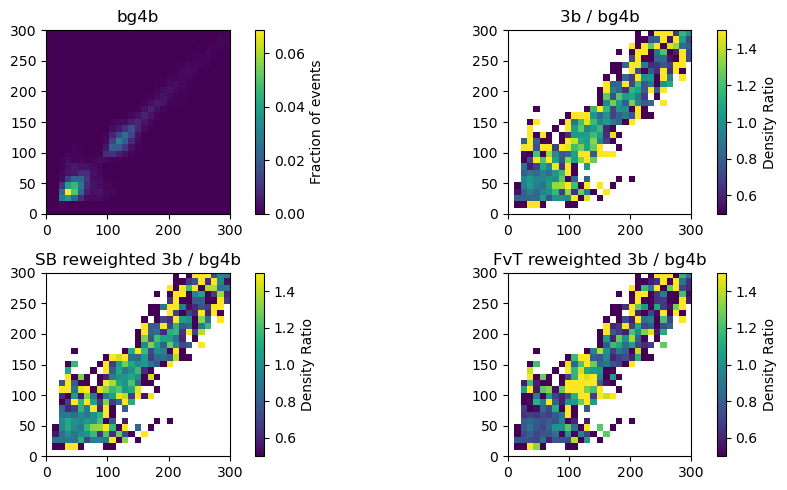

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

total_3b_sb = np.sum(w_sb[is_3b_sb])
total_4b_sb = np.sum(w_sb[is_4b_sb])

total_3b_sr = np.sum(w_sr[is_3b_sr])
total_4b_sr = np.sum(w_sr[is_4b_sr])

total_3b_fvt = np.sum(w_test[is_3b_test])
total_4b_fvt = np.sum(w_test[is_4b_test])

sb_reweight_const = (total_4b_sr / total_3b_sr) / (total_4b_sb / total_3b_sb)
fvt_reweight_const = (total_4b_sr / total_3b_sr) / (total_4b_fvt / total_3b_fvt)

reweights_sb_sr = w_sr * np.where(
    is_3b_sr, sb_reweight_const * (probs_4b_sb_sr / (1 - probs_4b_sb_sr)), 1
)
reweights_fvt_sr = w_sr * np.where(
    is_3b_sr, fvt_reweight_const * (probs_4b_fvt_sr / (1 - probs_4b_fvt_sr)), 1
)

m_0_sr = m_0[is_in_sr]
m_1_sr = m_1[is_in_sr]

x_bins = np.linspace(0, 300, 30)
y_bins = np.linspace(0, 300, 30)

hist_bg4b_sr, _, _ = np.histogram2d(m_0_sr[is_bg4b_sr], m_1_sr[is_bg4b_sr], bins=(x_bins, y_bins), weights=w_sr[is_bg4b_sr])
hist_3b_sr, _, _ = np.histogram2d(m_0_sr[is_3b_sr], m_1_sr[is_3b_sr], bins=(x_bins, y_bins), weights=w_sr[is_3b_sr])
hist_rwsb3b_sr, _, _ = np.histogram2d(m_0_sr[is_3b_sr], m_1_sr[is_3b_sr], bins=(x_bins, y_bins), weights=reweights_sb_sr[is_3b_sr])
hist_rwfvt3b_sr, _, _ = np.histogram2d(m_0_sr[is_3b_sr], m_1_sr[is_3b_sr], bins=(x_bins, y_bins), weights=reweights_fvt_sr[is_3b_sr])

hist_bg4b_sr /= np.sum(hist_bg4b_sr)
hist_3b_sr /= np.sum(hist_3b_sr)
hist_rwsb3b_sr /= np.sum(hist_rwsb3b_sr)
hist_rwfvt3b_sr /= np.sum(hist_rwfvt3b_sr)

im = ax[0, 0].imshow(hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis")
cbar = plt.colorbar(im, ax=ax[0, 0])
cbar.set_label("Fraction of events")
ax[0, 0].set_title("bg4b")

im = ax[0, 1].imshow(hist_3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
cbar = plt.colorbar(im, ax=ax[0, 1])
cbar.set_label("Density Ratio")
ax[0, 1].set_title("3b / bg4b")

im = ax[1, 0].imshow(hist_rwsb3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
cbar = plt.colorbar(im, ax=ax[1, 0])
cbar.set_label("Density Ratio")
ax[1, 0].set_title("SB reweighted 3b / bg4b")

im = ax[1, 1].imshow(hist_rwfvt3b_sr.T / hist_bg4b_sr.T, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis", vmin=0.5, vmax=1.5)
cbar = plt.colorbar(im, ax=ax[1, 1])
cbar.set_label("Density Ratio")
ax[1, 1].set_title("FvT reweighted 3b / bg4b")

plt.tight_layout()
plt.show()
plt.close()